In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# syle et context taille de la police
sns.set_theme(style="whitegrid", context="notebook")
# 11x6 → bon ratio pour affichage écran / 16:9, meilleure lisibilité
plt.rcParams["figure.figsize"] = (11, 6)

# Liens de ces fichiers pour analyse
candidates = [
    '../data/robots_missions.csv',
]

In [13]:
# DataFrame
robots = pd.read_csv(candidates[0])

robots.info()

<class 'pandas.DataFrame'>
RangeIndex: 5409 entries, 0 to 5408
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           5409 non-null   str    
 1   robot_id            5409 non-null   str    
 2   robot_type          5409 non-null   str    
 3   zone                5409 non-null   str    
 4   task_type           5409 non-null   str    
 5   mission_duration_s  5409 non-null   int64  
 6   downtime_s          5409 non-null   int64  
 7   battery_pct         5409 non-null   float64
 8   speed_mps           5409 non-null   float64
 9   temperature_c       5409 non-null   float64
 10  error_code          247 non-null    str    
 11  mission_status      5409 non-null   str    
 12  incident_label      5409 non-null   int64  
dtypes: float64(3), int64(3), str(7)
memory usage: 549.5 KB


In [14]:
robots.head()

,timestamp,robot_id,robot_type,zone,task_type,mission_duration_s,downtime_s,battery_pct,speed_mps,temperature_c,error_code,mission_status,incident_label
0,2026-02-02 08:00:00,R01,picker,C1,replenish,174,18,94.46,1.081,25.06,NaN,completed,0
1,2026-02-02 08:00:00,R09,forklift,A1,inventory_scan,179,19,93.04,1.197,22.87,NaN,completed,0
2,2026-02-02 08:10:00,R03,picker,C3,transport,219,13,90.91,1.257,25.00,NaN,completed,0
3,2026-02-02 08:10:00,R01,picker,D1,inventory_scan,242,27,98.40,1.537,25.04,NaN,completed,0
4,2026-02-02 08:20:00,R10,carrier,B2,pick,187,31,98.21,1.082,22.39,NaN,completed,0


In [15]:
robots["timestamp"] = pd.to_datetime(robots["timestamp"], errors="coerce")

In [16]:
robots.info()

<class 'pandas.DataFrame'>
RangeIndex: 5409 entries, 0 to 5408
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           5409 non-null   datetime64[us]
 1   robot_id            5409 non-null   str           
 2   robot_type          5409 non-null   str           
 3   zone                5409 non-null   str           
 4   task_type           5409 non-null   str           
 5   mission_duration_s  5409 non-null   int64         
 6   downtime_s          5409 non-null   int64         
 7   battery_pct         5409 non-null   float64       
 8   speed_mps           5409 non-null   float64       
 9   temperature_c       5409 non-null   float64       
 10  error_code          247 non-null    str           
 11  mission_status      5409 non-null   str           
 12  incident_label      5409 non-null   int64         
dtypes: datetime64[us](1), float64(3), int64(3), str(6)
memory u

In [21]:
if robots["timestamp"].isna().sum() > 0 : print("error Nat sur timestamp")
else : print("aucune erreur")

aucune erreur


In [31]:
df = pd.DataFrame({
    "timestamp": ["2025-01-01", "invalid_date"]
})

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

print(df)

   timestamp
0 2025-01-01
1        NaT


In [27]:
num_cols = ['mission_duration_s', 'downtime_s', 'battery_pct', 'speed_mps', 'temperature_c']
for c in num_cols:
    robots[c] = pd.to_numeric(robots[c], errors='coerce')

In [32]:
robots = robots.rename(columns={
    "timestamp": "event_ts",
    "robot_id" : "id",
    "robot_type": "type",
    "task_type": "task",
    "mission_duration_s": "duration",
    "downtime_s": "downtime",
    "battery_pct": "battery_level",
    "temperature_c": "temperature",
    "mission_status": "status",
    "incident_label": "incident",
    "error_code" : "error"
})

In [33]:
robots.head()

,event_ts,id,type,zone,task,duration,downtime,battery_level,speed_mps,temperature,error,status,incident
0,2026-02-02 08:00:00,R01,picker,C1,replenish,174,18,94.46,1.081,25.06,NaN,completed,0
1,2026-02-02 08:00:00,R09,forklift,A1,inventory_scan,179,19,93.04,1.197,22.87,NaN,completed,0
2,2026-02-02 08:10:00,R03,picker,C3,transport,219,13,90.91,1.257,25.00,NaN,completed,0
3,2026-02-02 08:10:00,R01,picker,D1,inventory_scan,242,27,98.40,1.537,25.04,NaN,completed,0
4,2026-02-02 08:20:00,R10,carrier,B2,pick,187,31,98.21,1.082,22.39,NaN,completed,0


In [38]:
(robots["downtime"] > 0).sum() 

np.int64(5115)

In [39]:
robots.shape

(5409, 13)

In [48]:
# Suppression des doublons
robots = robots.drop_duplicates()

# Conserver uniquement les missions dont la durée est strictement positive
robots = robots[robots["duration"] > 0]

# Conserver uniquement les pourcentages de batterie valides (entre 0 et 100 inclus)
robots = robots[robots["battery_level"].between(0, 100)]

robots["hour"] = robots["event_ts"].dt.hour
robots["day"] = robots["event_ts"].dt.date
robots["is_error"] = np.where(robots["error"].notna(), 1, 0)
# Mesurer l'efficience 
robots["efficiency"] = robots["duration"] / ( robots["downtime"] + robots["duration"] )

In [50]:
(robots["efficiency"] == 1).sum()

np.int64(294)

In [42]:
(robots["duration"] < 0) 

0       False
1       False
2       False
3       False
4       False
        ...  
5404    False
5405    False
5406     True
5407    False
5408    False
Name: duration, Length: 5409, dtype: bool

In [44]:
# Suppression des doublons
robots = robots.drop_duplicates()

# Conserver uniquement les missions dont la durée est strictement positive
robots = robots[robots["duration"] > 0]

# Conserver uniquement les pourcentages de batterie valides (entre 0 et 100 inclus)
robots = robots[robots["battery_level"].between(0, 100)]

In [47]:
((robots["duration"] < 0)  == True).sum()

np.int64(0)

In [53]:
robots[["id", "zone", "duration"]]

,id,zone,duration
0,R01,C1,174
1,R09,A1,179
2,R03,C3,219
3,R01,D1,242
4,R10,B2,187
...,...,...,...
5401,R01,B2,139
5402,R11,A1,227
5403,R04,A2,301
5404,R05,A2,156


In [54]:
df = pd.DataFrame({
    "product": ["A", "A", "B", "B", "B"],
    "quantity": [10, 15, 5, 8, 7]
})

df


,product,quantity
0,A,10
1,A,15
2,B,5
3,B,8
4,B,7


In [60]:
df.groupby("product").agg(
    total =("quantity", "mean")
)

,total
product,
A,12.500000
B,6.666667


In [64]:
# Regrouper toutes les missions qui ont eu lieu à la même heure de la journée.

"""
- missions → combien de missions ont été faites par heure
- error_rate → quel pourcentage de missions ont eu une erreur par heure
- avg_battery → niveau moyen de batterie par heure
"""

robots.groupby("hour").agg(
    mission = ("id", "count"),
    error_rate = ("error", ),
    avg_battery = ("battery_level", )
)


,mission
hour,
0,203
1,203
2,213
3,206
4,223
5,223
6,207
7,210
8,238


In [63]:
robots[["id", "hour"]]

,id,hour
0,R01,8
1,R09,8
2,R03,8
3,R01,8
4,R10,8
...,...,...
5401,R01,20
5402,R11,20
5403,R04,20
5404,R05,20


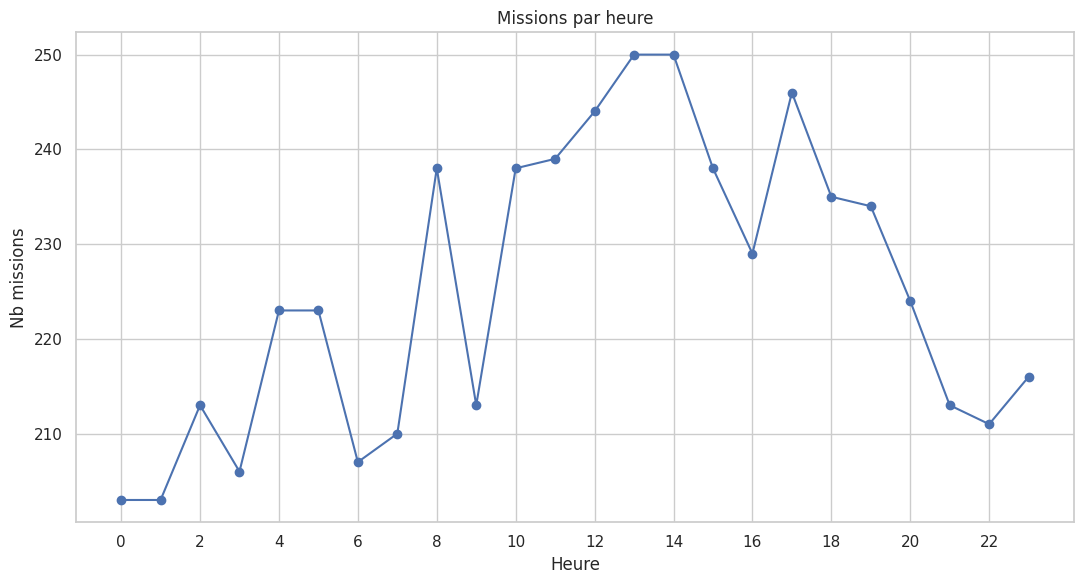

In [66]:
kpi_hour = robots.groupby("hour", as_index=False).agg(
    missions=("id", "count"),
    error_rate=("is_error", "mean"),
    avg_battery=("battery_level", "mean"),
)

plt.plot(kpi_hour["hour"], kpi_hour["missions"], marker="o")
plt.title("Missions par heure")
plt.xlabel("Heure")
plt.ylabel("Nb missions")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

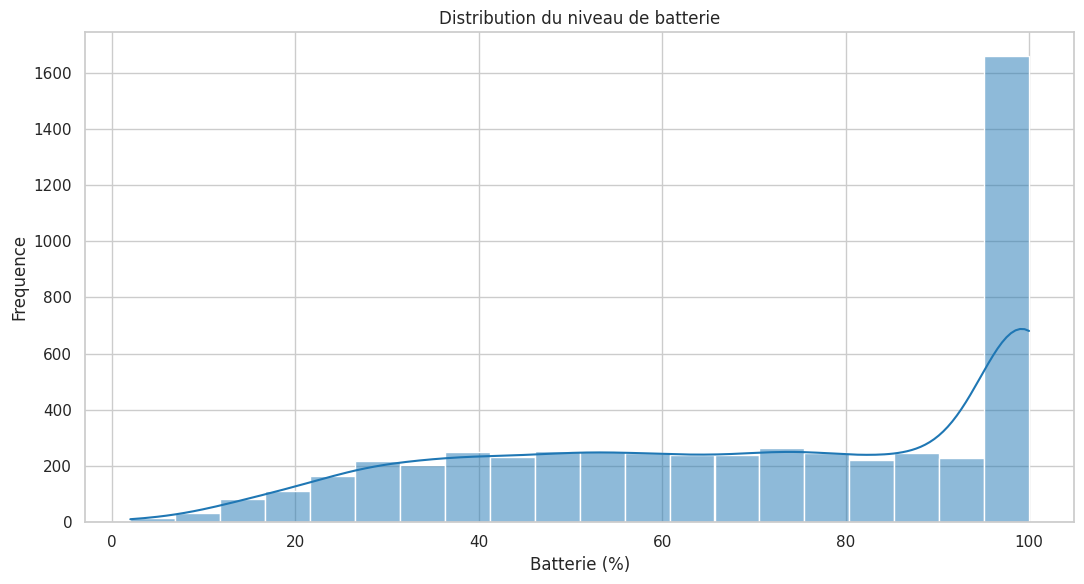

In [67]:
sns.histplot(robots, x="battery_level", bins=20, kde=True, color="#1f77b4")
plt.title("Distribution du niveau de batterie")
plt.xlabel("Batterie (%)")
plt.ylabel("Frequence")
plt.tight_layout()
plt.show()

In [71]:
robots["battery_bin"] = pd.cut(
    robots["battery_level"],
    bins=[0, 20, 50, 80, 100],
    labels=["0-20%", "20-50%", "50-80%", "80-100%"]
)

robots[["battery_bin", "id", "battery_level"]]

,battery_bin,id,battery_level
0,80-100%,R01,94.46
1,80-100%,R09,93.04
2,80-100%,R03,90.91
3,80-100%,R01,98.40
4,80-100%,R10,98.21
...,...,...,...
5401,20-50%,R01,21.44
5402,20-50%,R11,30.01
5403,20-50%,R04,32.11
5404,20-50%,R05,20.86


In [69]:
(robots["battery_level"] == 100).mean()

np.float64(0.26526082130965595)

In [78]:
error_by_battery = robots.groupby("battery_bin", as_index=False).agg(
    is_error=("is_error", "mean"),
)


In [79]:
error_by_battery

,battery_bin,is_error
0,0-20%,0.123810
1,20-50%,0.048350
2,50-80%,0.056542
3,80-100%,0.029933


In [80]:
error_by_battery["is_error"] *= 100

In [81]:
error_by_battery

,battery_bin,is_error
0,0-20%,12.380952
1,20-50%,4.834996
2,50-80%,5.654175
3,80-100%,2.993255


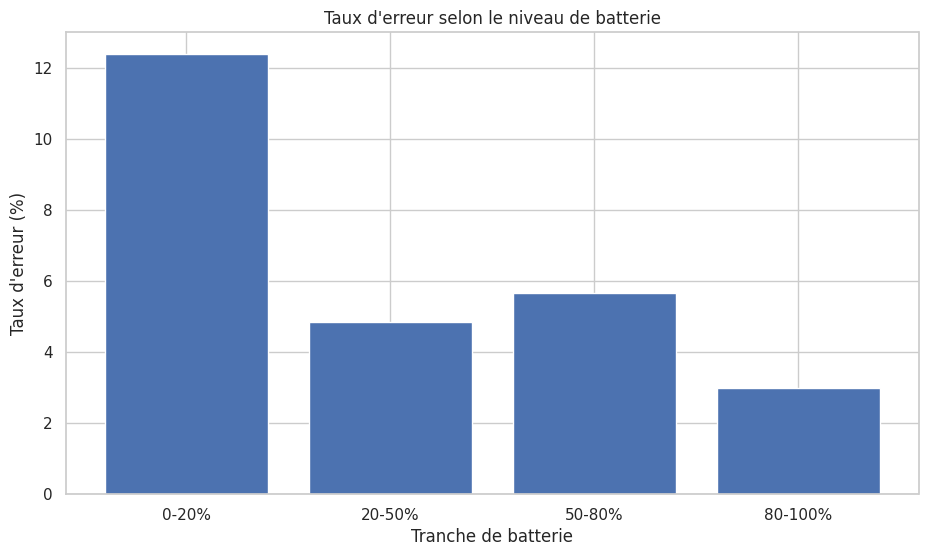

In [82]:
plt.figure()
plt.bar(
    error_by_battery["battery_bin"].astype(str),
    error_by_battery["is_error"]
)
plt.xlabel("Tranche de batterie")
plt.ylabel("Taux d'erreur (%)")
plt.title("Taux d'erreur selon le niveau de batterie")
plt.show()

In [83]:
zone_err = robots.groupby("zone", as_index=False).agg(
    is_error = ("is_error", "mean")
).sort_values("is_error", ascending=False)

In [84]:
zone_err

,zone,is_error
6,C3,0.081944
3,B2,0.062883
2,B1,0.047688
0,A1,0.045388
7,D1,0.037538
5,C2,0.033588
1,A2,0.030303
4,C1,0.022124


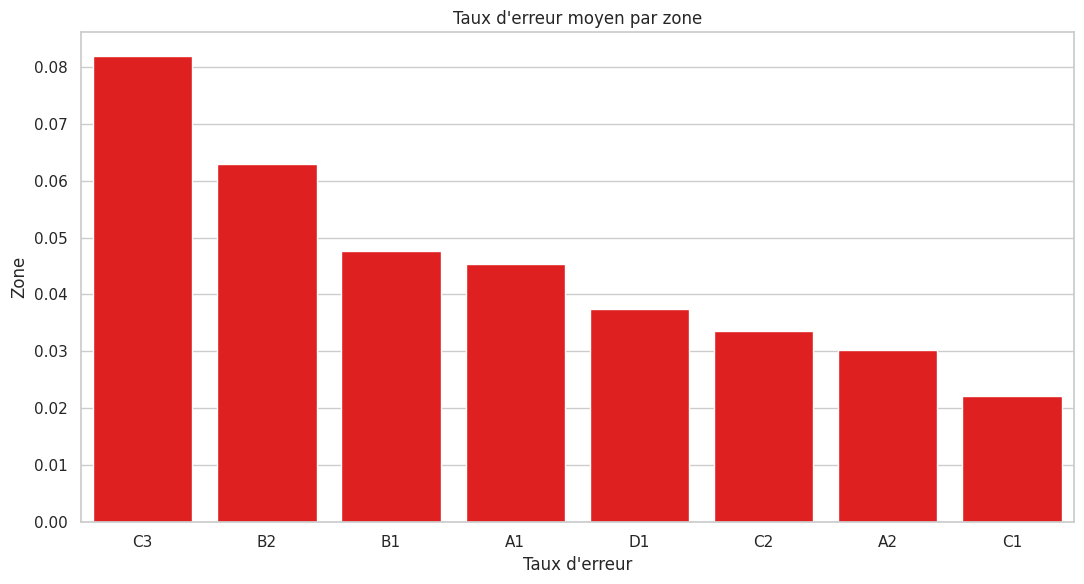

In [89]:
sns.barplot(data=zone_err, x="zone", y="is_error", color="red")
plt.title("Taux d'erreur moyen par zone")
plt.xlabel("Taux d'erreur")
plt.ylabel("Zone")
plt.tight_layout()
plt.show()

In [90]:
s = pd.Series([10, 12, 13, 15, 18, 19, 20, 100])

In [91]:
def upper_whisker(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    
    return q3 + 1.5 * iqr

In [92]:
upper_whisker(s)

29.0

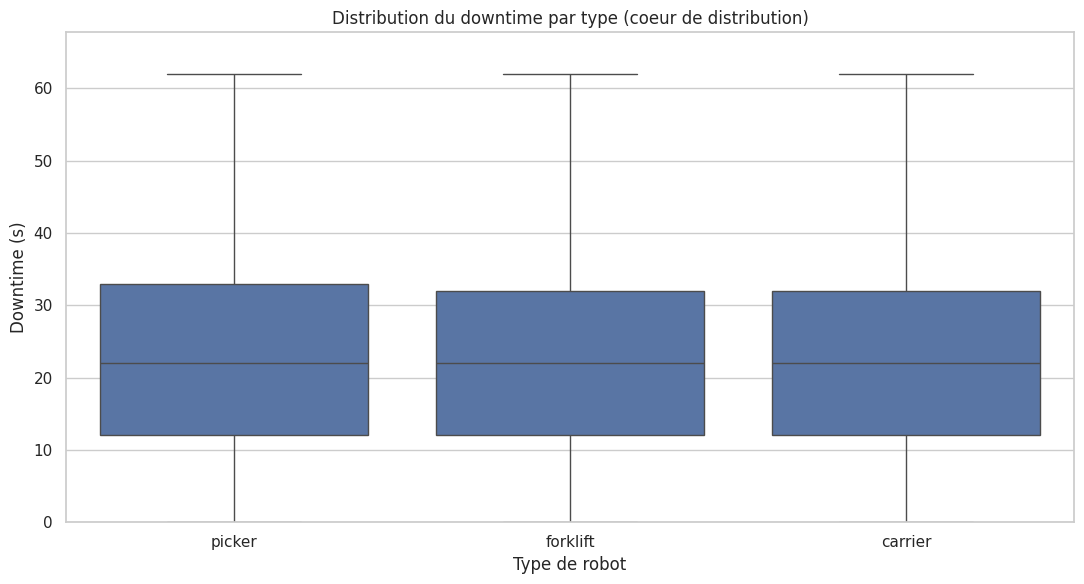

In [93]:
upper = robots.groupby("type")["downtime"].apply(upper_whisker).max()
sns.boxplot(data=robots, x="type", y="downtime", showfliers=False)
plt.ylim(0, upper * 1.05)
plt.title("Distribution du downtime par type (coeur de distribution)")
plt.xlabel("Type de robot")
plt.ylabel("Downtime (s)")
plt.tight_layout()
plt.show()

In [98]:
s = df.loc[df["type"] == "carrier", "downtime"]
q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
nb_outliers = ((s < low) | (s > high)).sum()

KeyError: 'type'

In [99]:
s = robots.loc[robots["type"] == "carrier", "downtime"]
q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
nb_outliers = ((s < low) | (s > high)).sum()

In [100]:
nb_outliers

np.int64(83)

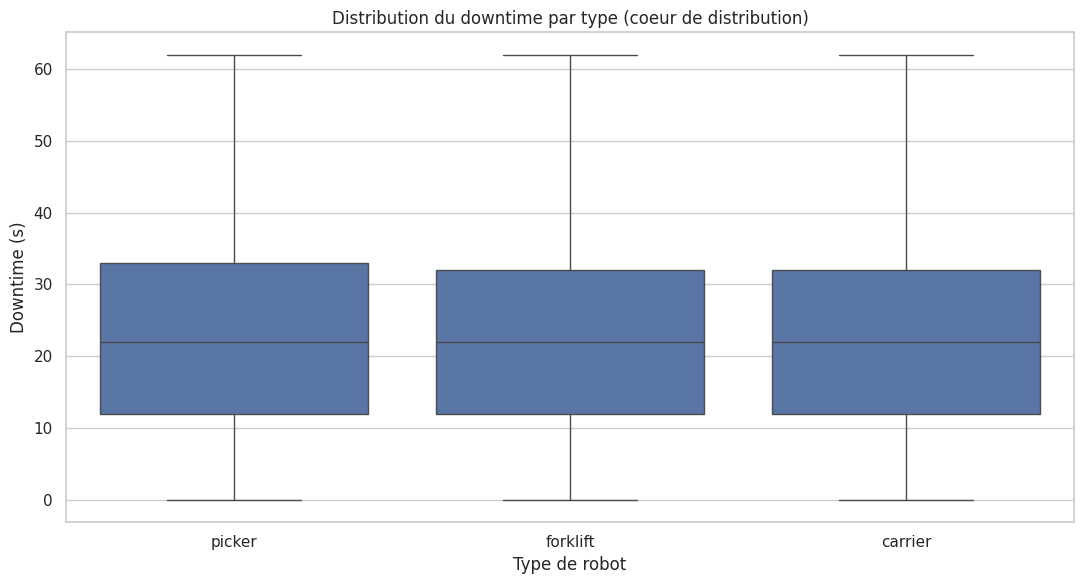

In [102]:
upper = robots.groupby("type").agg(
    max_downtime=("downtime", "max"),
    upper_whisker=("downtime", upper_whisker)
)
sns.boxplot(data=robots, x="type", y="downtime", showfliers=False)
plt.title("Distribution du downtime par type (coeur de distribution)")
plt.xlabel("Type de robot")
plt.ylabel("Downtime (s)")
plt.tight_layout()
plt.show()

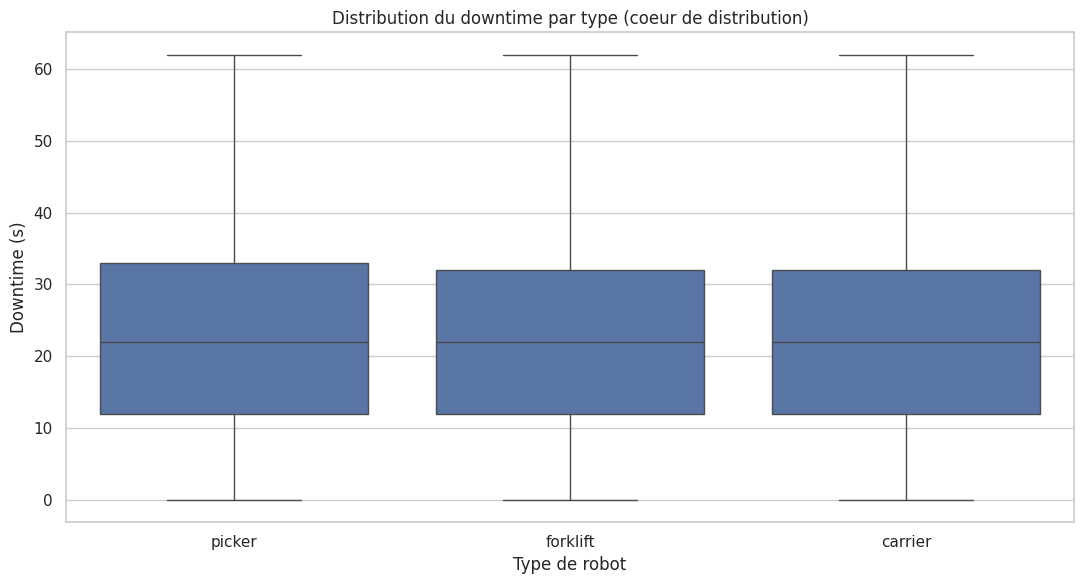

In [108]:
sns.boxplot(data=robots, x="type", y="downtime", showfliers=False)
plt.title("Distribution du downtime par type (coeur de distribution)")
plt.xlabel("Type de robot")
plt.ylabel("Downtime (s)")
plt.tight_layout()
plt.show()
